In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import AUC

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from datasets import load_dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/agnimagarwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# PATHS
data_path = '../data/'
notebooks = '../notebooks/'
models = '../models/'

# DATASET
DATASET_COLUMNS = ["message", "class"]
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 50
EPOCHS = 20
BATCH_SIZE = 16

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = models + "model.h5"
WORD2VEC_MODEL = models + "model.w2v"
TOKENIZER_MODEL = models + "tokenizer.pkl"
ENCODER_MODEL = models + "encoder.pkl"

In [4]:
df_orig = pd.read_csv('Train_Hate_All.csv')
df_orig = df_orig.rename(columns={'Hate_Speech': 'label'})
df_orig = df_orig.replace(0, -1)
df_orig.head()

,tweet,label
0,"@RexHuppke Ah fuck him, sounds like he'll be d...",-1
1,@mariaaraujo98 @Val_Voshchevska @angelasingh24...,1
2,@GenePark @myhlee @PostBaron @mboorstein Don't...,-1
3,@peterbakernyt Sanders can choke on his dandruff.,-1
4,@realDonaldTrump @FoxNews Fox News aka the Tru...,-1


In [17]:
def decode_sentiment(label):
    if label > 0:
        return "POSITIVE"
    elif label < 0:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

In [29]:
datasets_raw = [load_dataset('hate_offensive'), 
                load_dataset('hate_speech_offensive'), 
                load_dataset('tweets_hate_speech_detection'),
                load_dataset('hate_speech18')]
datasets = []
for db in datasets_raw:
    data = list(db['train'])
    df = pd.DataFrame(data=data)
    if 'text' in df.columns:
        df['tweet'] = df['text']
    if 'class' in df.columns:
        df['label'] = df['class']
    df = df[['tweet', 'label']]
    df['label'] = df['label'].apply(lambda x: decode_sentiment(x))
    datasets.append(df)
datasets.append(df_orig)
df_all = pd.concat(datasets)[['tweet', 'label']]
df_all.head()

2021-06-21 00:33:12,478 : WARNING : Using custom data configuration default
2021-06-21 00:33:12,483 : WARNING : Reusing dataset hate_offensive (/Users/agnimagarwal/.cache/huggingface/datasets/hate_offensive/default/1.1.0/7f48a7e24238043a2af5b4bba475a27ba7c0f20df73baf37023b832977efe137)
2021-06-21 00:33:12,806 : WARNING : Using custom data configuration default
2021-06-21 00:33:12,810 : WARNING : Reusing dataset hate_speech_offensive (/Users/agnimagarwal/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)
2021-06-21 00:33:13,096 : WARNING : Using custom data configuration default
2021-06-21 00:33:13,100 : WARNING : Reusing dataset tweets_hate_speech_detection (/Users/agnimagarwal/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/b85ae55489e4a8c3531632a1b4e654546689115add2a15f8bbf0ecbd779ef3ff)
2021-06-21 00:33:13,352 : WARNING : Using custom data configuration default
2021-06-21 00:33:13,3

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,POSITIVE
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,POSITIVE
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,POSITIVE
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,POSITIVE
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,POSITIVE


In [19]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df_all['tweet'] = df_all['tweet'].apply(lambda x: preprocess(x))
for df in datasets:
    df['tweet'] = df['tweet'].apply(lambda x: preprocess(x))

In [20]:
documents = [_text.split() for _text in df_all.tweet] 
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
# words = w2v_model.wv.vocab.keys()
vocab_size = len(w2v_model.wv)
print("Vocab size", vocab_size)

2021-06-21 00:32:07,983 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2021-06-21T00:32:07.983731', 'gensim': '4.0.1', 'python': '3.8.8 (default, Feb 24 2021, 13:46:16) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'created'}
2021-06-21 00:32:07,987 : INFO : collecting all words and their counts
2021-06-21 00:32:07,988 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-21 00:32:08,008 : INFO : PROGRESS: at sentence #10000, processed 83132 words, keeping 15569 word types
2021-06-21 00:32:08,035 : INFO : PROGRESS: at sentence #20000, processed 185720 words, keeping 27201 word types
2021-06-21 00:32:08,057 : INFO : PROGRESS: at sentence #30000, processed 271649 words, keeping 30081 word types
2021-06-21 00:32:08,078 : INFO : PROGRESS: at sentence #40000, processed 356714 words, keeping 30081 word types
2021-06-21 00:32:08,101 : INFO : PROGRESS: at sentence #50000, pr

Vocab size 8921


In [21]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-06-21 00:32:08,468 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 8921 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=7', 'datetime': '2021-06-21T00:32:08.468108', 'gensim': '4.0.1', 'python': '3.8.8 (default, Feb 24 2021, 13:46:16) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'train'}
2021-06-21 00:32:08,884 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 00:32:08,899 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 00:32:08,901 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 00:32:08,903 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 00:32:08,904 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 00:32:08,912 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 00:32:08,913 : INFO : worker thread finished; awaiting finish 

2021-06-21 00:32:12,711 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 00:32:12,720 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 00:32:12,722 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 00:32:12,723 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 00:32:12,724 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 00:32:12,726 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 00:32:12,730 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-21 00:32:12,730 : INFO : EPOCH - 10 : training on 918939 raw words (706845 effective words) took 0.4s, 1698078 effective words/s
2021-06-21 00:32:13,139 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 00:32:13,157 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 00:32:13,161 : INFO : worker thre

2021-06-21 00:32:16,491 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 00:32:16,495 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-21 00:32:16,496 : INFO : EPOCH - 19 : training on 918939 raw words (706442 effective words) took 0.4s, 1799225 effective words/s
2021-06-21 00:32:16,914 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 00:32:16,916 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 00:32:16,919 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 00:32:16,920 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 00:32:16,921 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 00:32:16,928 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 00:32:16,929 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 00:32:16,931 : INFO : worker thre

2021-06-21 00:32:20,701 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 00:32:20,713 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-21 00:32:20,715 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-21 00:32:20,716 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-21 00:32:20,717 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-21 00:32:20,725 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-21 00:32:20,726 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-21 00:32:20,726 : INFO : EPOCH - 29 : training on 918939 raw words (706769 effective words) took 0.4s, 1690096 effective words/s
2021-06-21 00:32:21,114 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-21 00:32:21,116 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-21 00:32:21,130 : INFO : worker thre

(22616131, 29406048)

In [22]:
w2v_model.wv.most_similar("hate")

[('annoying', 0.4368670582771301),
 ('haters', 0.4347200095653534),
 ('referring', 0.4334990680217743),
 ('care', 0.37848278880119324),
 ('nerve', 0.3700076639652252),
 ('stand', 0.3593452572822571),
 ('brianstelter', 0.3544588088989258),
 ('dislike', 0.3491138219833374),
 ('asshole', 0.347942054271698),
 ('bitchy', 0.34787657856941223)]

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_all.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 78660


In [24]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
print(vocab_size)
for word in w2v_model.wv.key_to_index:
    embedding_matrix[w2v_model.wv.key_to_index[word]] = w2v_model.wv[word]
print(embedding_matrix.shape)

78660
(78660, 100)


In [25]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


In [26]:
model = Sequential()
model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           7866000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 7,931,429
Trainable params: 65,429
Non-trainable params: 7,866,000
_________________________________________________________________


In [32]:
for df in datasets:
    # min sample size
    min_length = 1e10
    for i in df['label'].unique().tolist():
        curr_length = len(df[df['label'] == i])
        if curr_length != 0 and curr_length < min_length:
            min_length = curr_length

    # undersample
    df_arr = []
    for i in df['label'].unique().tolist():
        df_arr.append(df[df['label'] == i].sample(min_length))

    df = pd.concat(df_arr)
    df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
    
    x_train = pad_sequences(tokenizer.texts_to_sequences(df_train['tweet']), maxlen=SEQUENCE_LENGTH)
    x_test = pad_sequences(tokenizer.texts_to_sequences(df_test['tweet']), maxlen=SEQUENCE_LENGTH)
    
    # decode labels
    labels = df_train['label'].unique().tolist()
    labels.append(NEUTRAL)
    
    encoder = LabelEncoder()
    encoder.fit(df_train['label'].tolist())

    y_train = encoder.transform(df_train['label'].tolist())
    y_test = encoder.transform(df_test['label'].tolist())

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

    print("y_train",y_train.shape)
    print("y_test",y_test.shape)
    
    
    # fit model
    callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                  EarlyStopping(monitor='val_auc', min_delta=1e-4, patience=5)]
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.25,
                        verbose=1,
                        callbacks=callbacks,
                        shuffle=True)

y_train (2288, 1)
y_test (572, 1)
Epoch 1/20
108/108 [==============================] - 1s 6ms/step - loss: 85.3037 - auc: 0.5413 - val_loss: 34.1010 - val_auc: 0.5574
Epoch 2/20
108/108 [==============================] - 0s 3ms/step - loss: 15.8116 - auc: 0.6367 - val_loss: 13.6816 - val_auc: 0.6163
Epoch 3/20
108/108 [==============================] - 0s 3ms/step - loss: 6.2477 - auc: 0.7371 - val_loss: 12.1560 - val_auc: 0.6227
Epoch 4/20
108/108 [==============================] - 0s 3ms/step - loss: 3.5777 - auc: 0.8038 - val_loss: 8.8340 - val_auc: 0.6299
Epoch 5/20
108/108 [==============================] - 0s 3ms/step - loss: 2.2032 - auc: 0.8497 - val_loss: 7.6202 - val_auc: 0.6522
Epoch 6/20
108/108 [==============================] - 0s 4ms/step - loss: 1.1719 - auc: 0.9146 - val_loss: 7.1695 - val_auc: 0.6414
y_train (2288, 1)
y_test (572, 1)
Epoch 1/20
108/108 [==============================] - 0s 4ms/step - loss: 5.0563 - auc: 0.6997 - val_loss: 4.3261 - val_auc: 0.7018
Epo

In [33]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

23/23 [==============================] - 0s 2ms/step - loss: 1.8740 - auc: 0.7522

ACCURACY: 0.7521732449531555
LOSS: 1.8740381002426147


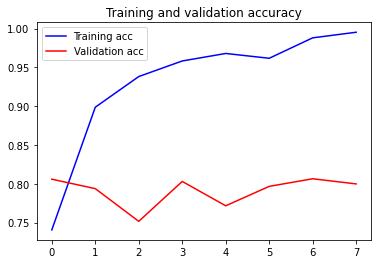

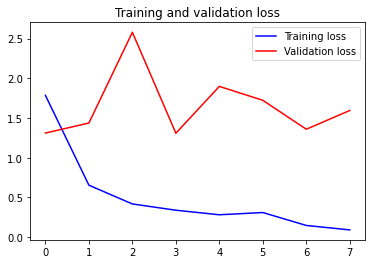

In [34]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict('I hate the weather')

{'label': 'NEGATIVE',
 'score': 0.0005826056003570557,
 'elapsed_time': 0.2882089614868164}

In [38]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-06-21 00:37:03,698 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-06-21T00:37:03.698135', 'gensim': '4.0.1', 'python': '3.8.8 (default, Feb 24 2021, 13:46:16) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'saving'}
2021-06-21 00:37:03,699 : INFO : not storing attribute cum_table
2021-06-21 00:37:03,711 : INFO : saved model.w2v


In [40]:
rma = pd.read_csv(data + 'election_sample_RMA.csv')
rma.head()

TypeError: can only concatenate list (not "str") to list